In [70]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [71]:
# Load the dataset (replace 'dataset.csv' with your dataset file)
data = pd.read_csv('churn.csv')

In [72]:
#Data Preprocessing
#Change value in  column
data['Geography'] = data['Geography'].replace(['Germany'],'0')
data['Geography'] = data['Geography'].replace(['France'],'1')
data['Geography'] = data['Geography'].replace(['Spain'],'2')

#Change value in gender column
data['Gender'] = data['Gender'].replace(['Female'],'0')
data['Gender'] = data['Gender'].replace(['Male'],'1')

#convert object data types column to integer
data['Geography'] = pd.to_numeric(data['Geography'])
data['Gender'] = pd.to_numeric(data['Gender'])
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography            int64
Gender               int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [73]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,1,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,1,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,1,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,1,1,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,1,1,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,1,0,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,0,1,42,3,75075.31,2,1,0,92888.52,1


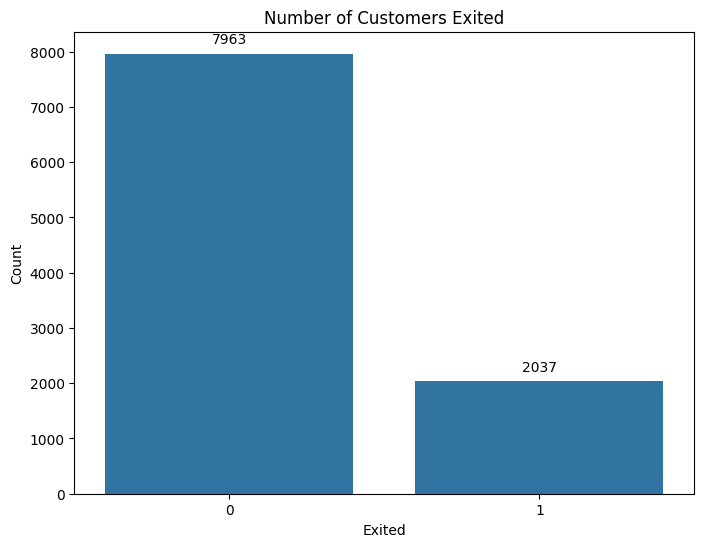

In [74]:
# Visualize the distribution of the target variable (churn) EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Create the count plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Exited', data=data)

# Add annotations
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

# Show the plot
plt.xlabel('Exited')
plt.ylabel('Count')
plt.title('Number of Customers Exited')
plt.show()


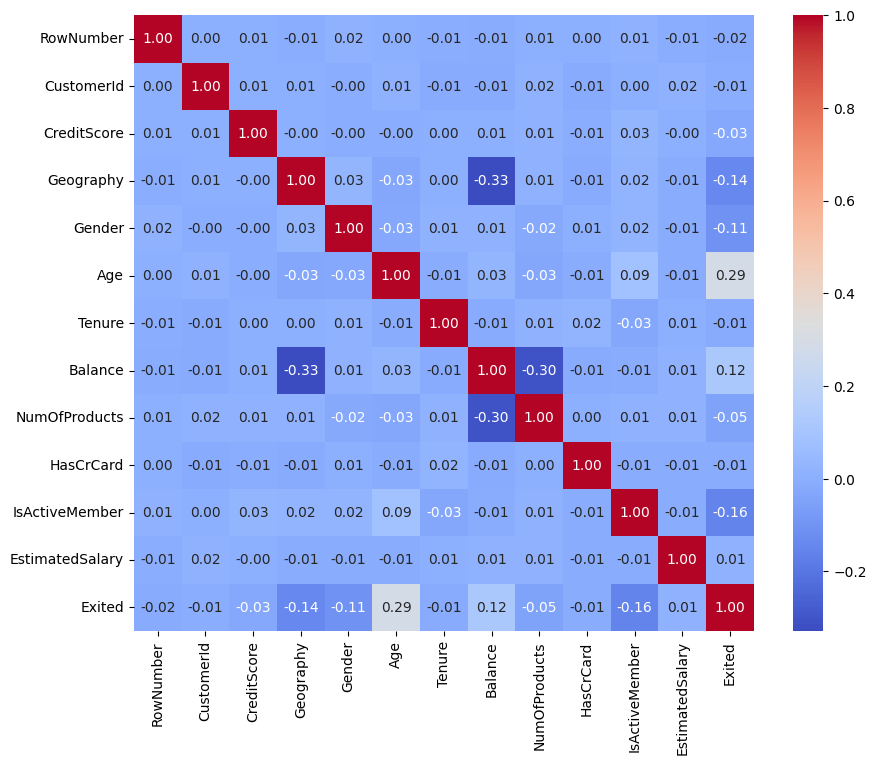

In [75]:
# Check the correlation matrix
# Exclude non-numeric columns from the correlation matrix calculation
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

# Plot the correlation matrix

# Plot the correlation matrix with larger cells and font size
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.show()



In [76]:
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                 RowNumber  CustomerId  CreditScore  Geography    Gender  \
RowNumber         1.000000    0.004202     0.005840  -0.006028  0.018196   
CustomerId        0.004202    1.000000     0.005308   0.006670 -0.002641   
CreditScore       0.005840    0.005308     1.000000  -0.000478 -0.002857   
Geography        -0.006028    0.006670    -0.000478   1.000000  0.025446   
Gender            0.018196   -0.002641    -0.002857   0.025446  1.000000   
Age               0.000783    0.009497    -0.003965  -0.029824 -0.027544   
Tenure           -0.006495   -0.014883     0.000842   0.002713  0.014733   
Balance          -0.009067   -0.012419     0.006268  -0.328736  0.012087   
NumOfProducts     0.007246    0.016972     0.012238   0.011923 -0.021859   
HasCrCard         0.000599   -0.014025    -0.005458  -0.014734  0.005766   
IsActiveMember    0.012044    0.001665     0.025651   0.022807  0.022544   
EstimatedSalary  -0.005988    0.015271    -0.001384  -0.010285 -0.00

In [77]:
data.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)

In [78]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,1,0,42,8,159660.80,3,1,0,113931.57,1
3,699,1,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,1,39,5,0.00,2,1,0,96270.64,0
9996,516,1,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,1,0,36,7,0.00,1,0,1,42085.58,1
9998,772,0,1,42,3,75075.31,2,1,0,92888.52,1


In [82]:
'''# Split the data into features and target variable
X = data.drop('Exited', axis=1)  # Features
y = data['Exited']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)'''

In [100]:
# Perform one-hot encoding for categorical variables
data_encoded = pd.get_dummies(data)

# Split the data into features and target variable
X = data_encoded.drop('Exited', axis=1)
y = data_encoded['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

# Make predictions on the test set
dtree_y_pred = dtree.predict(X_test)
print("Decision Tree Accuracy Score :", accuracy_score(y_test, dtree_y_pred) * 100, "%")

Decision Tree Accuracy Score : 82.0 %


In [101]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_y_pred = lgr.predict(X_test)
print("Logistic Regression Accuracy Score :", accuracy_score(y_test, lgr_y_pred)*100, "%")

Logistic Regression Accuracy Score : 80.35 %


In [103]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)
print("Random Forest Accuracy Score :", accuracy_score(y_test, rfc_y_pred)*100, "%")

Random Forest Accuracy Score : 84.89999999999999 %


In [87]:
print("Classification report:")
print(classification_report(y_test,rfc_y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



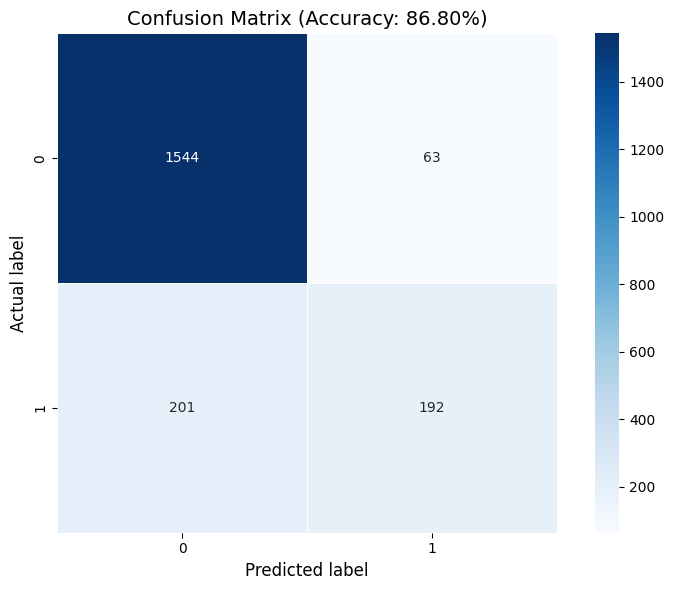

In [88]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix and accuracy score
cm = confusion_matrix(y_test, rfc_y_pred)
accuracy = accuracy_score(y_test, rfc_y_pred)

# Create a figure and axes objects with a larger size
plt.figure(figsize=(8, 6))

# Plot confusion matrix as a heatmap
sns.heatmap(data=cm, linewidths=0.5, annot=True, fmt="d", cmap='Blues', square=True)


plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.title('Confusion Matrix (Accuracy: {:.2f}%)'.format(accuracy * 100), size=14)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


In [89]:
cm1 = confusion_matrix(y_test, rfc_y_pred)
cm2 = confusion_matrix(y_test, dtree_y_pred)
cm3 = confusion_matrix(y_test, lgr_y_pred)



In [90]:
print(cm1)
print(cm2)
print(cm3)

[[1544   63]
 [ 201  192]]
[[1361  246]
 [ 196  197]]
[[1571   36]
 [ 361   32]]


In [91]:
#Decision Tree Classification Report
print("Classification report:")
print(classification_report(y_test,dtree_y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1607
           1       0.44      0.50      0.47       393

    accuracy                           0.78      2000
   macro avg       0.66      0.67      0.67      2000
weighted avg       0.79      0.78      0.78      2000



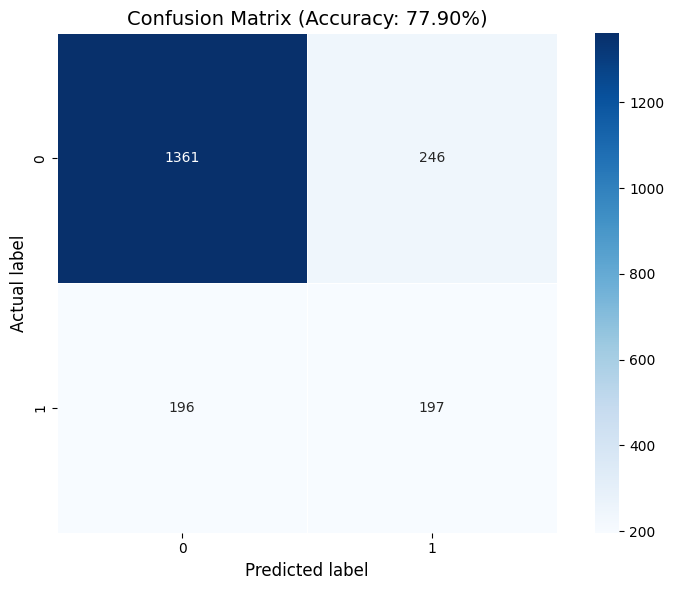

In [92]:
#Decision Tree
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix and accuracy score
cm = confusion_matrix(y_test, dtree_y_pred)
accuracy = accuracy_score(y_test, dtree_y_pred)

# Create a figure and axes objects with a larger size
plt.figure(figsize=(8, 6))

# Plot confusion matrix as a heatmap
sns.heatmap(data=cm, linewidths=0.5, annot=True, fmt="d", cmap='Blues', square=True)


plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.title('Confusion Matrix (Accuracy: {:.2f}%)'.format(accuracy * 100), size=14)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

In [93]:
#Logistic Regression
print("Classification report:")
print(classification_report(y_test,lgr_y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1607
           1       0.47      0.08      0.14       393

    accuracy                           0.80      2000
   macro avg       0.64      0.53      0.51      2000
weighted avg       0.75      0.80      0.74      2000



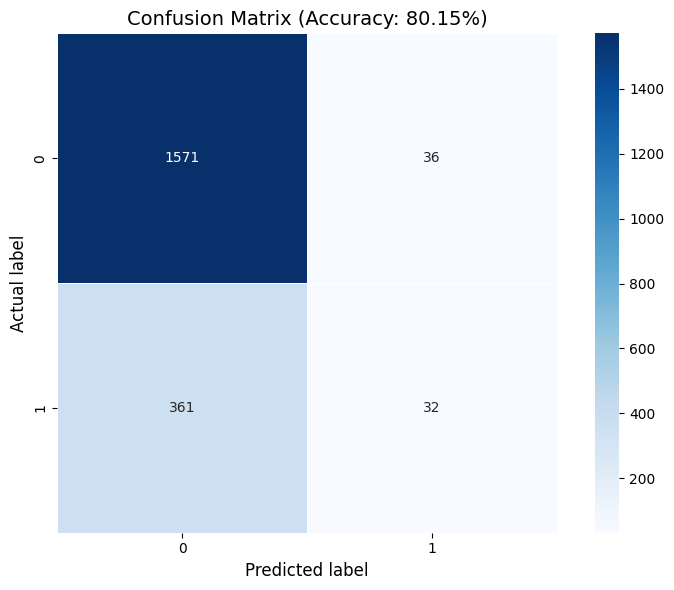

In [94]:
#Logistic Regression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix and accuracy score
cm = confusion_matrix(y_test, lgr_y_pred)
accuracy = accuracy_score(y_test, lgr_y_pred)

# Create a figure and axes objects with a larger size
plt.figure(figsize=(8, 6))

# Plot confusion matrix as a heatmap
sns.heatmap(data=cm, linewidths=0.5, annot=True, fmt="d", cmap='Blues', square=True)


plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.title('Confusion Matrix (Accuracy: {:.2f}%)'.format(accuracy * 100), size=14)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

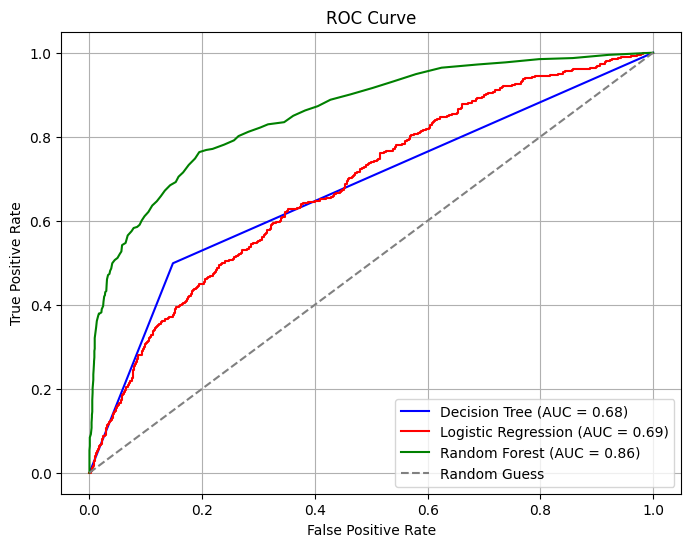

In [95]:
#ROC curve
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Initialize and train Logistic Regression classifier
lgr_classifier = LogisticRegression(random_state=42)
lgr_classifier.fit(X_train, y_train)

# Initialize and train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict probabilities for positive class
y_probs_dt = dt_classifier.predict_proba(X_test)[:, 1]
y_probs_rf = rf_classifier.predict_proba(X_test)[:, 1]
y_probs_lgr =lgr_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_probs_dt)
auc_dt = roc_auc_score(y_test, y_probs_dt)

# Compute ROC curve and AUC for Logistic Regression
fpr_lgr, tpr_lgr, _ = roc_curve(y_test, y_probs_lgr)
auc_lgr = roc_auc_score(y_test, y_probs_lgr)

# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
auc_rf = roc_auc_score(y_test, y_probs_rf)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})', color='blue')
plt.plot(fpr_lgr, tpr_lgr, label=f'Logistic Regression (AUC = {auc_lgr:.2f})', color='red')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

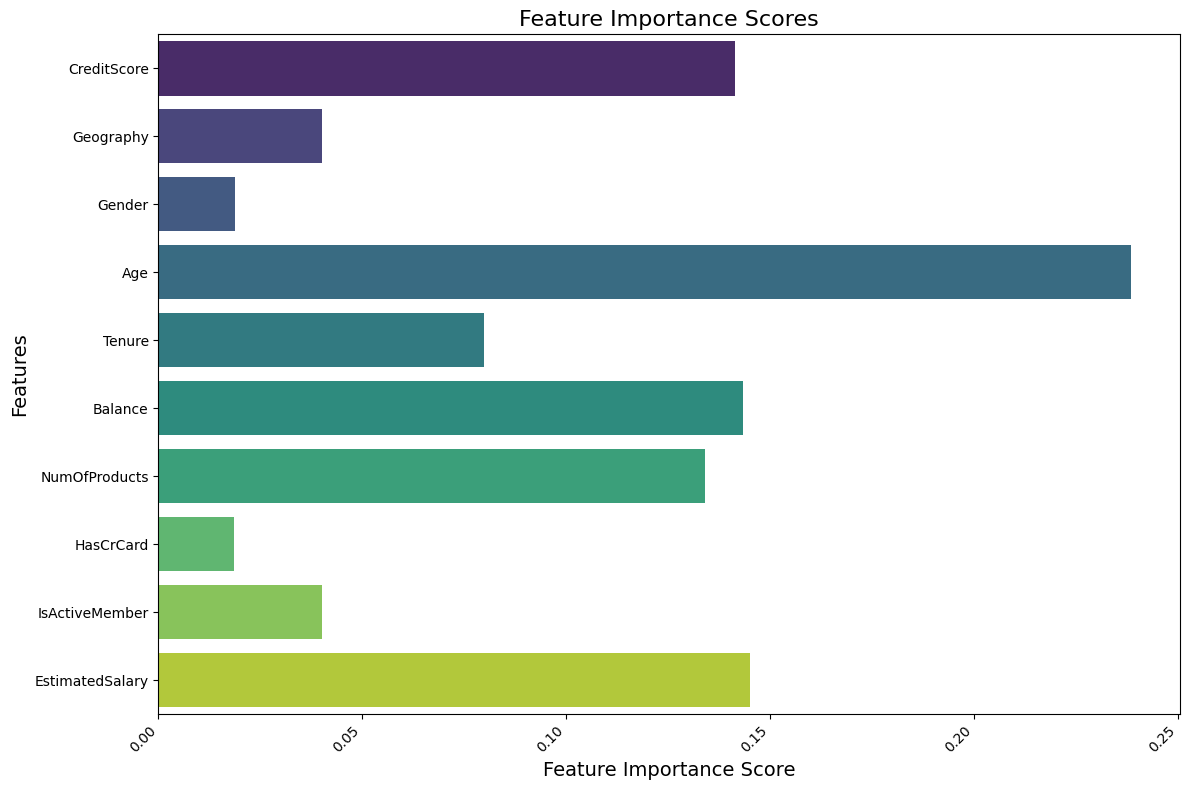

Feature Importance Values:
           Feature  Importance
3              Age    0.238653
9  EstimatedSalary    0.145081
5          Balance    0.143441
0      CreditScore    0.141396
6    NumOfProducts    0.134107
4           Tenure    0.079776
1        Geography    0.040132
8   IsActiveMember    0.040087
2           Gender    0.018732
7        HasCrCard    0.018593


In [107]:

# Load the dataset
data = pd.read_csv('churn.csv')

# Drop non-numeric columns and encode categorical variables
data_encoded = data.drop(columns=['Surname', 'RowNumber', 'CustomerId'])  # Drop non-numeric columns

# Encode 'Geography' column
data_encoded['Geography'] = data_encoded['Geography'].replace({'Germany': 0, 'France': 1, 'Spain': 2})

# Encode 'Gender' column
data_encoded['Gender'] = data_encoded['Gender'].replace({'Female': 0, 'Male': 1})

# Handle any remaining non-numeric values or missing values

# Drop rows with missing values
data_encoded.dropna(inplace=True)

# Split the data into features and target variable
X = data_encoded.drop('Exited', axis=1)  # Features
y = data_encoded['Exited']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=X.columns, palette='viridis')
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance Scores', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate tick labels if necessary
plt.tight_layout()
plt.show()

# Print the feature importance values
print("Feature Importance Values:")
print(feature_importance_df.sort_values(by='Importance',ascending=False))
